In [194]:
import pandas as pd
import numpy as np
import os
import git
import pickle
from datetime import datetime
import nltk
nltk.download('vader_lexicon')
from tqdm.auto import tqdm
from dateutil.relativedelta import relativedelta
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', -1)
from tqdm.auto import tqdm
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/drew_william2345/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [5]:
def get_git_root(path):
    git_repo = git.Repo(path, search_parent_directories=True)
    git_root = git_repo.git.rev_parse("--show-toplevel")
    return git_root

In [6]:
top_dir = get_git_root(os.getcwd())
input_dir = os.path.join(top_dir,"input")
model_dir = os.path.join(top_dir,"models")

In [15]:
juul_data = pd.read_csv(os.path.join(input_dir,"juul_data.csv"),lineterminator="\n")
juul_data["tweetCreatedAt"] = pd.to_datetime(juul_data["tweetCreatedAt"])
user_data = pd.read_csv(os.path.join(input_dir,"user_data.csv"),lineterminator="\n")

In [5]:
## no of users
len(juul_data.userID.unique())

887180

## extarct the data for 2018 and look at the sentiments

### extract 2018 data 


In [8]:
sid = SentimentIntensityAnalyzer()
sid.polarity_scores("this is good")  ## test

{'neg': 0.0, 'neu': 0.408, 'pos': 0.592, 'compound': 0.4404}

In [40]:
## 67 % of retweet data
len(juul_data.loc[juul_data.retweeted == True]) / len(juul_data)

0.6757790593434232

In [18]:
pos_sentiment= []
neg_sentiment = []
neutral_sentiment = []
compound_sentiment = []
dates = []
start = datetime(2018,1,1)
for i in tqdm(range(12)):
    next_ = start + relativedelta(months=1)
    print(start.strftime("%b"))
    data = juul_data.loc[(juul_data["tweetCreatedAt"] >= start ) & (juul_data["tweetCreatedAt"] < next_)]
    print(len(data))
    count = 0
    pos_value = 0
    neg_value = 0
    neutral_value = 0
    compound_value= 0
    for sentence in tqdm(list(data.tweetText)):
        ss = sid.polarity_scores(sentence)
        pos_value += ss["pos"]
        neg_value += ss["neg"]
        neutral_value += ss["neu"]
        compound_value += ss["compound"]
        count += 1
    pos_sentiment.append(pos_value/ count)
    neg_sentiment.append(neg_value/ count)
    compound_sentiment.append(compound_value/ count)
    neutral_sentiment.append(neutral_value/ count)
    dates.append(start.strftime("%b"))
    start = next_

Jan
64275


Feb
57121


Mar
78153


Apr
102004


May
112754


Jun
134507


Jul
151713


Aug
155437


Sep
132445


Oct
154867


Nov
167740


Dec
162147


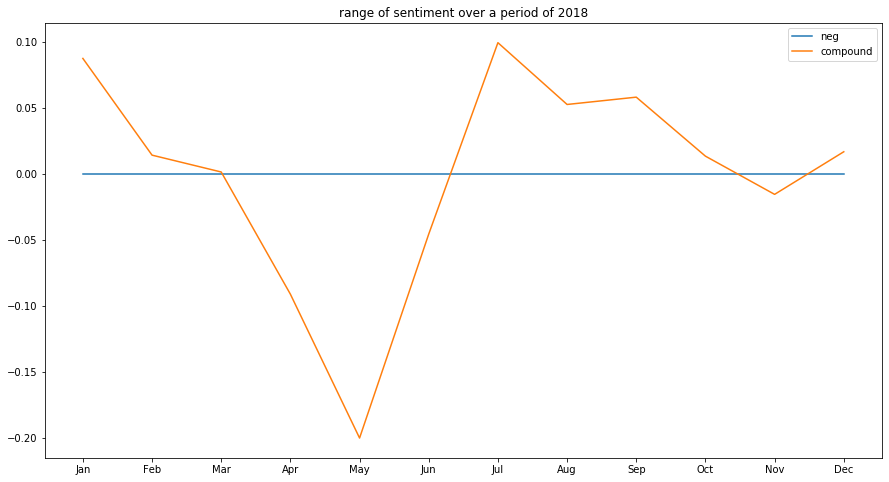

In [29]:
plt.figure(figsize=(15,8))
# dates = [str(date) for date in dates]
# plt.plot(dates,pos_sentiment,label="pos")
# plt.plot(dates,neg_sentiment,label="neg")
plt.plot(dates,np.zeros(len(dates)),label="neutral baseline")
plt.plot(dates,compound_sentiment,label="compound")
plt.title("range of sentiment over a period of 2018")
plt.legend()
plt.show()

## selecting 2018 data and seeing the sentiments of them

In [17]:
juul_2018 = juul_data.loc[(juul_data["tweetCreatedAt"] >= datetime(2018,1,1) ) & (juul_data["tweetCreatedAt"] < datetime(2018,12,31))]


In [12]:
classifier_dir = os.path.join(model_dir,"classifier","filter")
svm = pickle.load(open(os.path.join(classifier_dir,"svm_tf.pkl"),"rb"))
tf_idf = pickle.load(open(os.path.join(classifier_dir,"tf_idf_vect.pkl"),"rb"))

In [26]:
X = tf_idf.transform(juul_2018["tweetText"])

In [35]:
y = (svm.predict(X))

In [36]:
y.shape

(1471336,)

In [51]:
print("regular tweets",len([ele for ele in y if ele== 2]) / len(y),":",len([ele for ele in y if ele== 2]))
print("promoters tweets",len([ele for ele in y if ele== 1]) / len(y),":",len([ele for ele in y if ele== 1]) )
print("news tweets",len([ele for ele in y if ele== 0]) / len(y),":",len([ele for ele in y if ele== 0]))

regular tweets 0.694000554597998 : 1021108
promoters tweets 0.17742990044422213 : 261059
news tweets 0.12856954495777986 : 189169


In [52]:
juul_2018["label"] = y

/home/drew_william2345/anaconda3/envs/multimodal-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### capture regular users (max tweets of each category)

In [192]:
juul_ = pd.get_dummies(juul_2018,columns=["label"],prefix=['cat'])
juul_users_2018 = juul_.groupby(by="userID").agg({'cat_0': 'sum','cat_1':'sum','cat_2':'sum'})
juul_users_2018 = juul_users_2018.reset_index()
juul_users_2018["label"] = juul_users_2018[['cat_0','cat_1','cat_2']].idxmax(axis=1)
## sanity check
# regular tweets 1021108
(np.sum(list(juul_users_2018["cat_2"])))

1021108.0

### plotting each user in different category

regular_users 546396
promoters users 146993
news users, 113029
806418
806418


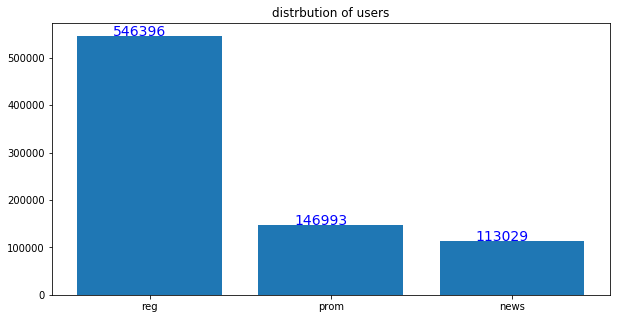

In [176]:
## no of users in each category
print("regular_users",len(juul_users_2018.loc[juul_users_2018.label == "cat_2"]))
print("promoters users",len(juul_users_2018.loc[juul_users_2018.label == "cat_1"]))
print("news users,",len(juul_users_2018.loc[juul_users_2018.label == "cat_0"]))
users_ = {"reg":len(juul_users_2018.loc[juul_users_2018.label == "cat_2"]),
 "prom":len(juul_users_2018.loc[juul_users_2018.label == "cat_1"]),
 "news":len(juul_users_2018.loc[juul_users_2018.label == "cat_0"])}

## sanity check
print(np.sum(list(users_.values())))
print(len(juul_users_2018.userID.unique()))

## plotting each user by category
fig, ax = plt.subplots(figsize=(10,5)) 
ax.set_title("distrbution of users")
ax.bar(users_.keys(),users_.values())
for idx,(key,value) in enumerate(users_.items()):
    ax.text( idx - 0.2 ,value + 0.5, value, color='blue',fontsize=14)

In [184]:
## predict teh sentiment of regualr users
juul_reg_users_18 = juul_users_2018.loc[juul_users_2018.label == "cat_2"]
users_18 = list(juul_reg_users_18.userID.unique())
reg_tweets_18 = juul_2018.loc[juul_2018.userID.isin(users_18)][["userID","tweetText"]]

In [191]:
print("reg users tweets '18",len(reg_tweets_18))
print("reg users in '18",len(reg_tweets_18.userID.unique()))

reg users tweets '18 1046205
reg users in '18 546396


In [ ]:
pos_sentiment= []
neg_sentiment = []
neutral_sentiment = []
compound_sentiment = []
dates = []
start = datetime(2018,1,1)
for i in tqdm(range(12)):
    next_ = start + relativedelta(months=1)
    print(start.strftime("%b"))
    ## filtering data of each month
    data = juul_data.loc[(juul_data["tweetCreatedAt"] >= start ) & (juul_data["tweetCreatedAt"] < next_)]
    print(len(reg_tweets_18))
    count = 0
    pos_value = 0
    neg_value = 0
    neutral_value = 0
    compound_value= 0
    for sentence in tqdm(list(data.tweetText)):
        ss = sid.polarity_scores(sentence)
        pos_value += ss["pos"]
        neg_value += ss["neg"]
        neutral_value += ss["neu"]
        compound_value += ss["compound"]
        count += 1
    pos_sentiment.append(pos_value/ count)
    neg_sentiment.append(neg_value/ count)
    compound_sentiment.append(compound_value/ count)
    neutral_sentiment.append(neutral_value/ count)
    dates.append(start.strftime("%b"))
    start = next_

Jan
1046205


Feb
1046205


Mar
1046205


Apr
1046205


May
1046205


In [ ]:
plt.figure(figsize=(15,8))
plt.plot(dates,np.zeros(len(dates)),label="neutral baseline")
plt.plot(dates,compound_sentiment,label="compound")
plt.title("range of sentiment over a period of 2018")
plt.legend()
plt.show()